In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import seaborn as sns
from IPython.display import display
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
pd.set_option('precision', 4)
plt.style.use('seaborn')

['train_full.csv']


## Data Overview

The data consisted of 12 columns (11 features and 1 labels) with 16135561 entries

In [2]:
data = pd.read_csv('../input/train_full.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16135561 entries, 0 to 16135560
Data columns (total 12 columns):
bookingID         int64
Accuracy          float64
Bearing           float64
acceleration_x    float64
acceleration_y    float64
acceleration_z    float64
gyro_x            float64
gyro_y            float64
gyro_z            float64
second            float64
Speed             float64
labels            int64
dtypes: float64(10), int64(2)
memory usage: 1.4 GB


We can first sort entries based on bookingid and then second, so we can maybe inspect sequential patterns easier.

In [3]:
data = data.sort_values(by = ['bookingID', 'second'])

We can see that there is no null-values, but this does not mean there is no null values, however later on we will see that there are anomalous values that might signifies missing values.

In [4]:
data.isnull().any()

bookingID         False
Accuracy          False
Bearing           False
acceleration_x    False
acceleration_y    False
acceleration_z    False
gyro_x            False
gyro_y            False
gyro_z            False
second            False
Speed             False
labels            False
dtype: bool

There are only 20000 samples(trip).

In [5]:
for col in data.columns :
    print(col , data[col].nunique())

bookingID 20000
Accuracy 49191
Bearing 2025092
acceleration_x 1308634
acceleration_y 1216585
acceleration_z 1941793
gyro_x 3104790
gyro_y 3404533
gyro_z 2611366
second 8266
Speed 6196574
labels 2


In [6]:
print('Not Grouped Positive/Negative labels ratio :', len(data[data['labels'] == 1])/len(data[data['labels'] == 0]))
data['labels'].value_counts()

Not Grouped Positive/Negative labels ratio : 0.4397569871069716


0    11207142
1     4928419
Name: labels, dtype: int64

In [7]:
grp = data.groupby('bookingID').agg({'labels':'mean'})
print('Grouped Positive/Negative labels ratio :', len(grp[grp['labels'] == 1])/len(grp[grp['labels'] == 0]))
grp['labels'].value_counts()

Grouped Positive/Negative labels ratio : 0.33253381304550605


0    15009
1     4991
Name: labels, dtype: int64

Based on these ratios we might hypothesize that there might be relation between trip length and safe driving and possibly on average longer trips are less safe than shorter ones (since there are more time stamps).

## Series Plot



Sample plot of series with label 0

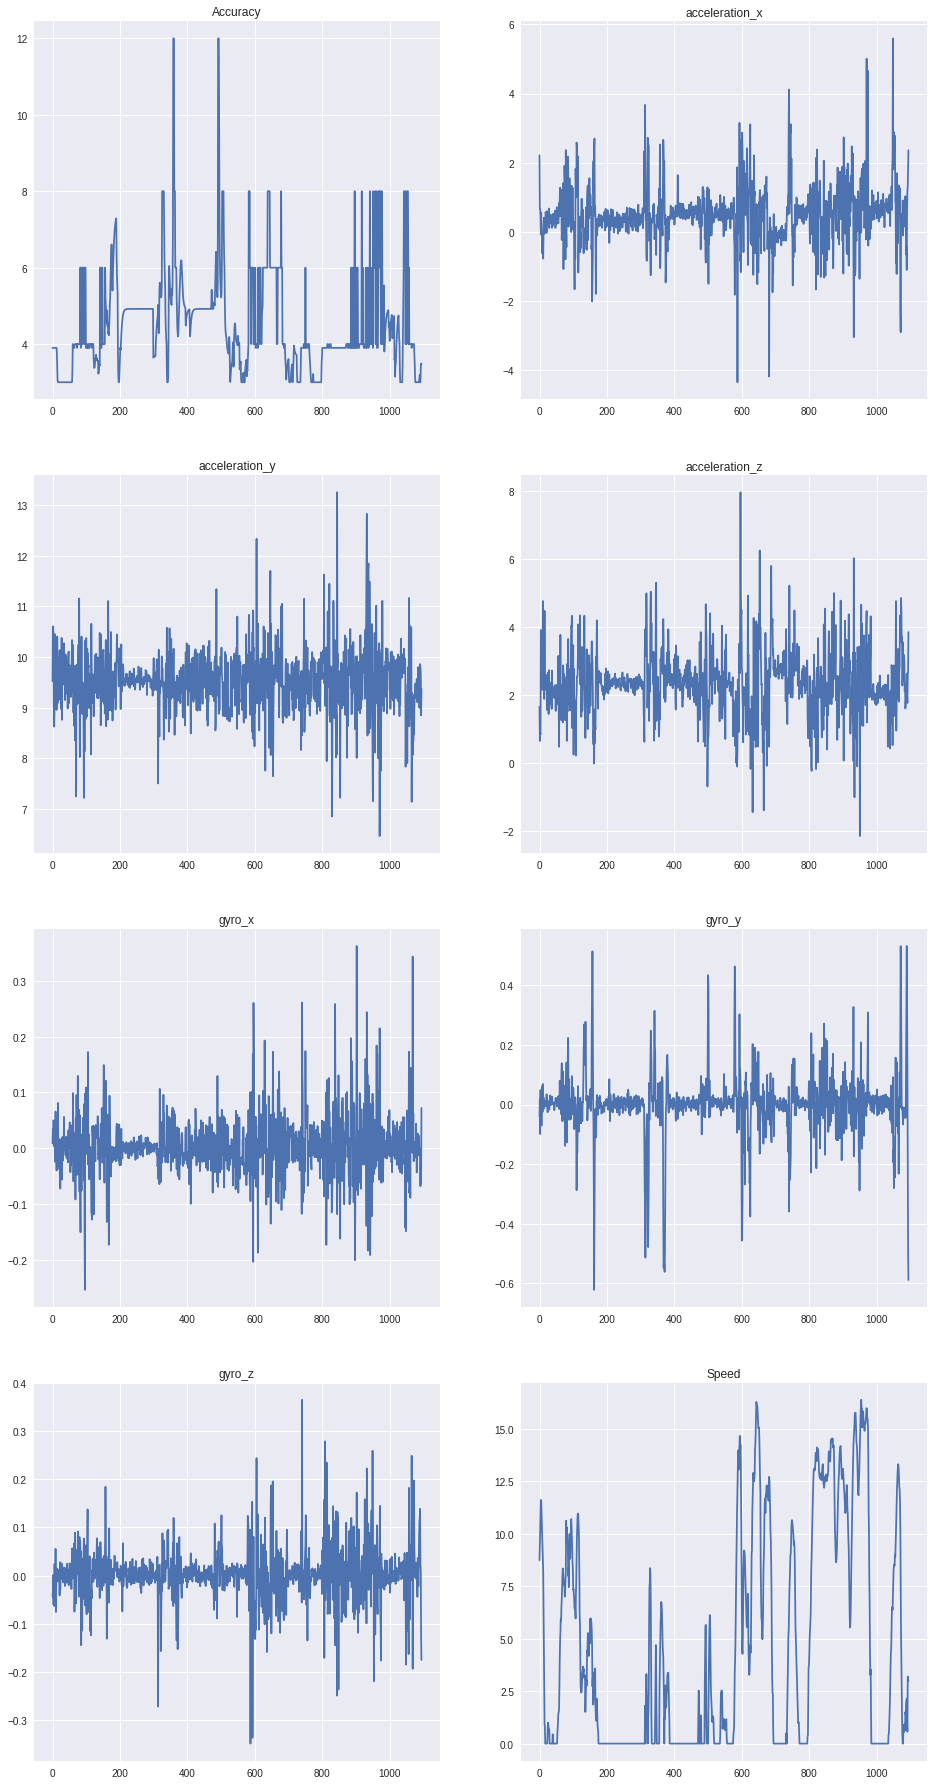

In [8]:
chk_id = 6

plotted_feats = [
    'Accuracy',
    "acceleration_x",
    'acceleration_y',
    'acceleration_z',
    'gyro_x',
    'gyro_y',
    'gyro_z',
    'Speed'
]

fig, ax = plt.subplots(nrows=4, ncols = 2 , figsize = (16,4*8))

for i in range(len(plotted_feats)) :
    show_ax = (i//2,i%2)
    ax[show_ax].plot(data[data['bookingID'] == chk_id]['second'] , data[data['bookingID'] == chk_id][plotted_feats[i]])
    ax[show_ax].set_title(plotted_feats[i])


Sample of plot of series with label 1

From these plots we can see that there are sometimes anomalous points within the series. from the plot below we can see sometimes speed becomes -1 (anomalous)

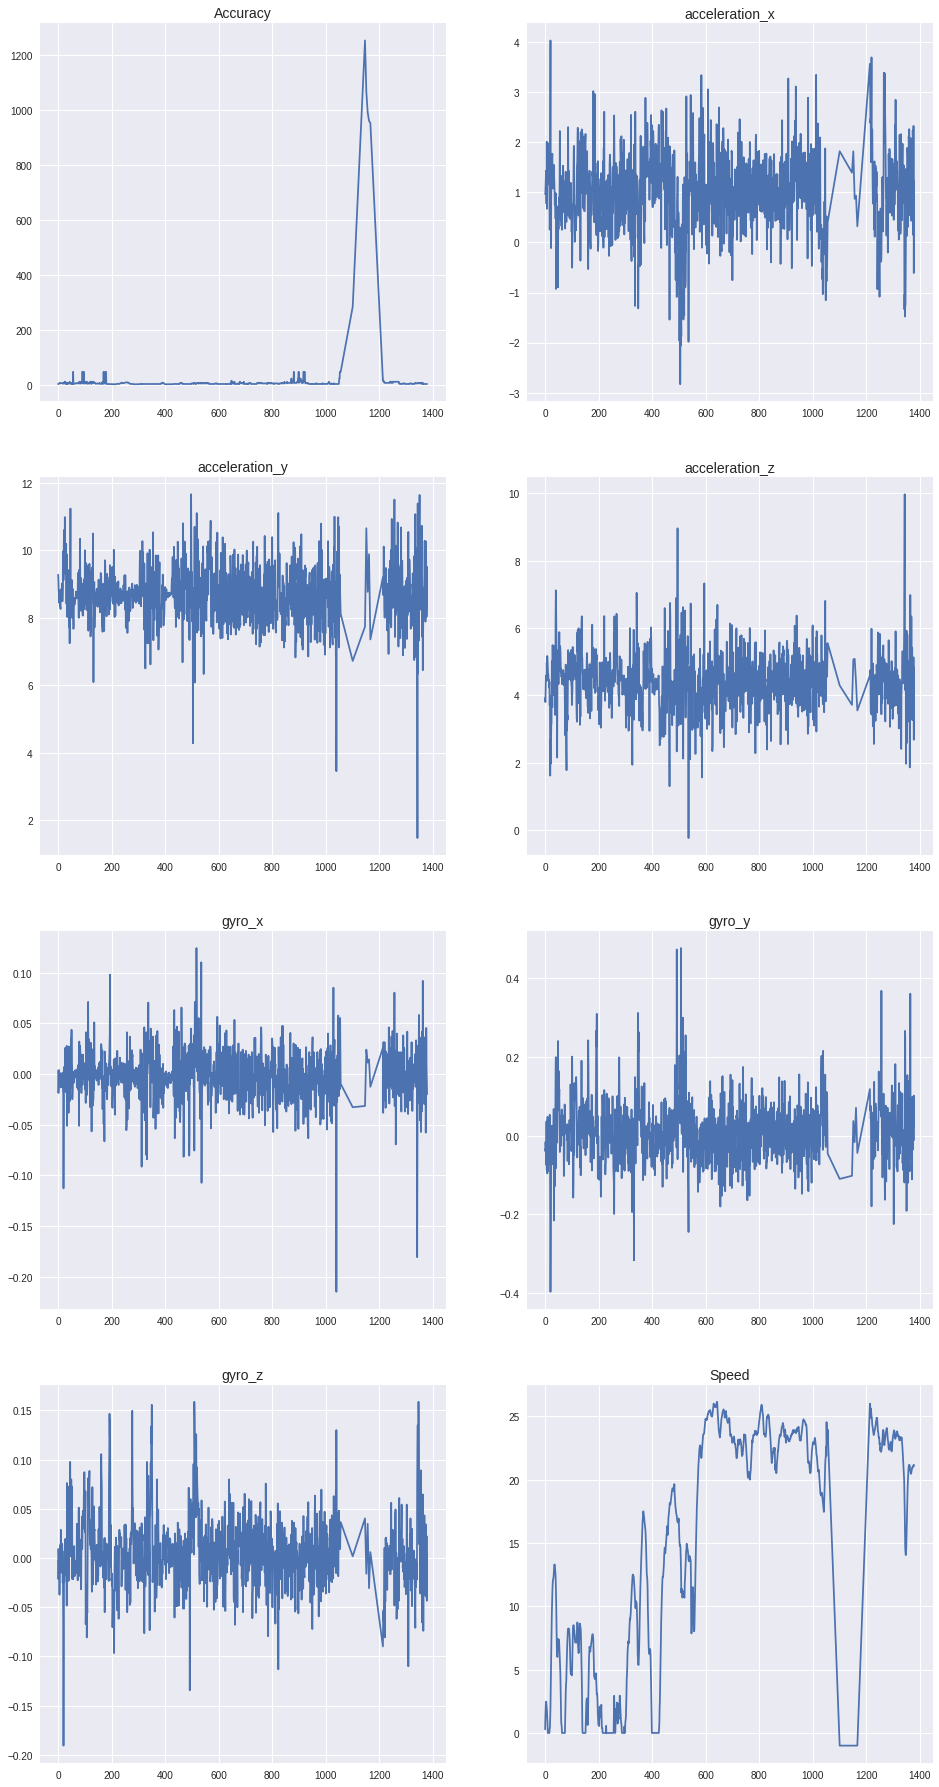

In [9]:
chk_id = 13

plotted_feats = [
    'Accuracy',
    "acceleration_x",
    'acceleration_y',
    'acceleration_z',
    'gyro_x',
    'gyro_y',
    'gyro_z',
    'Speed'
]

fig, ax = plt.subplots(nrows=4, ncols = 2 , figsize = (16,4*8))

for i in range(len(plotted_feats)) :
    show_ax = (i//2,i%2)
    ax[show_ax].plot(data[data['bookingID'] == chk_id]['second'] , data[data['bookingID'] == chk_id][plotted_feats[i]])
    ax[show_ax].set_title(plotted_feats[i] , fontsize = 14)

## Descriptive Statistics for each class

In [10]:
print('Label 0')
display(data[data['labels'] == 0].describe())

Label 0


,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,labels
count,1.1207e+07,1.1207e+07,1.1207e+07,1.1207e+07,1.1207e+07,1.1207e+07,1.1207e+07,1.1207e+07,1.1207e+07,1.1207e+07,1.1207e+07,1.1207e+07
mean,8.0413e+11,1.1090e+01,1.6961e+02,6.9171e-02,4.5274e+00,8.6436e-01,-1.9178e-03,5.9534e-04,-3.3741e-04,5.1465e+03,9.1786e+00,0.0000e+00
std,4.9290e+11,8.5945e+01,1.0677e+02,1.3155e+00,8.1913e+00,3.0621e+00,1.1846e-01,2.4969e-01,1.1394e-01,1.7239e+06,8.0735e+00,0.0000e+00
min,0.0000e+00,8.0000e-01,0.0000e+00,-3.3441e+01,-5.7800e+01,-7.8448e+01,-3.3472e+01,-7.4889e+01,-3.6512e+01,0.0000e+00,-1.7198e+00,0.0000e+00
25%,3.7796e+11,3.9000e+00,7.9000e+01,-4.9801e-01,-2.1500e+00,-9.1082e-01,-2.6704e-02,-2.9603e-02,-1.8378e-02,2.1700e+02,1.2600e+00,0.0000e+00
50%,7.7309e+11,4.0660e+00,1.6918e+02,6.1052e-02,9.1170e+00,7.5500e-01,-7.4768e-04,2.8100e-04,-3.4088e-05,4.7000e+02,7.8800e+00,0.0000e+00
75%,1.2112e+12,8.0000e+00,2.6248e+02,6.2491e-01,9.7184e+00,2.6698e+00,2.2969e-02,3.1036e-02,1.8096e-02,7.8000e+02,1.5650e+01,0.0000e+00
max,1.7008e+12,6.0701e+03,3.6000e+02,4.7708e+01,6.1159e+01,6.3657e+01,3.9840e+01,6.2542e+01,6.6301e+01,1.4958e+09,5.6699e+01,0.0000e+00


In [11]:
print('Label 1')
display(data[data['labels'] == 1].describe())

Label 1


,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,labels
count,4.9284e+06,4.9284e+06,4.9284e+06,4.9284e+06,4.9284e+06,4.9284e+06,4.9284e+06,4.9284e+06,4.9284e+06,4.9284e+06,4.9284e+06,4928419.0
mean,8.5111e+11,1.2794e+01,1.6752e+02,6.9088e-02,4.3360e+00,9.6237e-01,-1.2403e-03,-4.3684e-04,-7.4046e-05,7.4948e+02,8.6153e+00,1.0
std,4.9900e+11,8.9075e+01,1.0848e+02,1.6448e+00,7.9895e+00,3.6450e+00,1.9108e-01,4.8667e-01,2.0561e-01,5.6621e+02,8.1673e+00,0.0
min,1.0000e+00,7.5000e-01,0.0000e+00,-7.8420e+01,-7.2994e+01,-7.5937e+01,-4.8456e+01,-5.7345e+01,-5.3554e+01,0.0000e+00,-2.0000e+00,1.0
25%,4.1232e+11,3.9000e+00,7.5000e+01,-5.3372e-01,-1.8793e+00,-9.8166e-01,-2.6915e-02,-3.0893e-02,-1.9548e-02,3.2400e+02,5.4000e-01,1.0
50%,8.5899e+11,4.4260e+00,1.6700e+02,6.2057e-02,8.9914e+00,8.2798e-01,-4.4838e-04,2.3213e-04,-4.3982e-05,6.6000e+02,6.7000e+00,1.0
75%,1.2799e+12,8.0000e+00,2.6300e+02,6.6136e-01,9.6886e+00,2.9497e+00,2.4243e-02,3.2229e-02,1.8646e-02,1.0620e+03,1.5059e+01,1.0
max,1.7094e+12,4.6183e+03,3.6000e+02,6.6873e+01,7.5056e+01,7.8056e+01,3.0709e+01,8.0315e+01,5.5949e+01,8.2350e+03,1.4802e+02,1.0


## Correlation Heatmap

Directly using these features shows no correlations with the labels

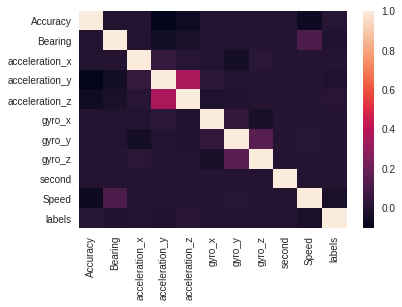

In [12]:
sns.heatmap(data.loc[:,data.columns != 'bookingID'].corr())
plt.show()